In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score

In [3]:
!curl -O https://lazyprogrammer.me/course_files/sp500sub.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
  0 24.2M    0  6130    0     0   3291      0  2:09:00  0:00:01  2:08:59  3297
  1 24.2M    1  350k    0     0   121k      0  0:03:25  0:00:02  0:03:23  121k
  5 24.2M    5 1406k    0     0   375k      0  0:01:06  0:00:03  0:01:03  376k
 18 24.2M   18 4686k    0     0  1008k      0  0:00:24  0:00:04  0:00:20 1009k
 35 24.2M   35 8910k    0     0  1578k      0  0:00:15  0:00:05  0:00:10 2114k
 55 24.2M   55 13.5M    0     0  2026k      0  0:00:12  0:00:06  0:00:06 2784k
 70 24.2M   70 17.1M    0     0  2195k      0  0:00:11  0:00:07  0:00:04 3369k
 81 24.2M   81 19.8M    0     0  2285k      0  0:00:10  0:00:08  0:00:02 3669k
 96 24.2M   96 23.4M    0     0  2494k      0  0:00

In [7]:
# to see the file before convering to df
with open("sp500sub.csv", "r") as file:
    lines = file.readlines()

# Display the first 5 lines
for line in lines[:5]:
    print(line.strip())

Date,Open,High,Low,Close,Adj Close,Volume,Name
2010-01-04,9.220000267028807,9.510000228881836,9.170000076293944,9.5,9.5,1865400.0,INCY
2010-01-05,9.510000228881836,10.289999961853027,9.449999809265137,10.270000457763672,10.270000457763672,7608900.0,INCY
2010-01-06,10.380000114440918,11.09000015258789,10.350000381469727,11.0,11.0,8046700.0,INCY
2010-01-07,11.0,11.0600004196167,10.619999885559082,10.81999969482422,10.81999969482422,3680300.0,INCY


In [8]:
df=pd.read_csv('sp500sub.csv',index_col='Date',parse_dates=True)
df.head()

,Open,High,Low,Close,Adj Close,Volume,Name
Date,,,,,,,
2010-01-04,9.22,9.51,9.17,9.50,9.50,1865400.0,INCY
2010-01-05,9.51,10.29,9.45,10.27,10.27,7608900.0,INCY
2010-01-06,10.38,11.09,10.35,11.00,11.00,8046700.0,INCY
2010-01-07,11.00,11.06,10.62,10.82,10.82,3680300.0,INCY
2010-01-08,10.82,11.00,10.75,10.94,10.94,1529300.0,INCY


In [9]:
goog=df[df['Name']=='GOOG'][['Close']].copy()

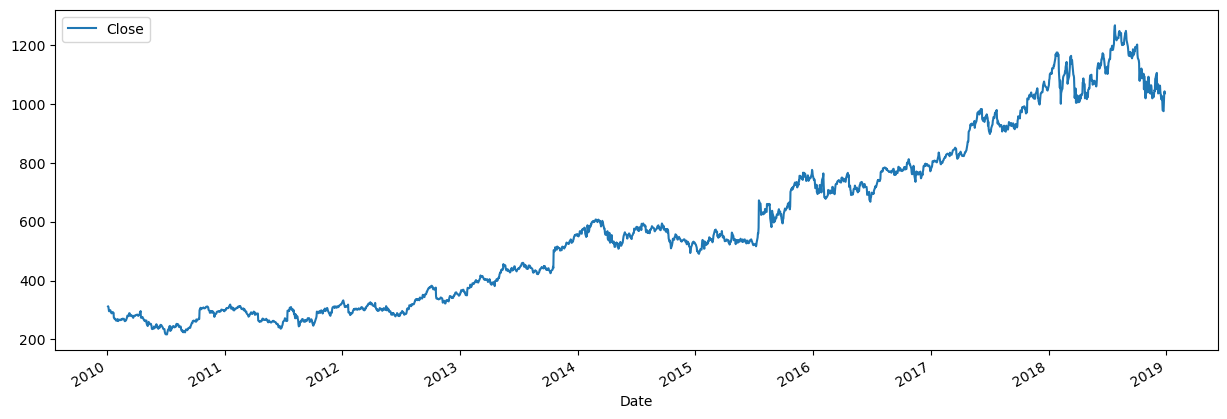

In [10]:
goog.plot(figsize=(15,5));

In [11]:
goog['LogClose']=np.log(goog['Close'])

<Axes: xlabel='Date'>

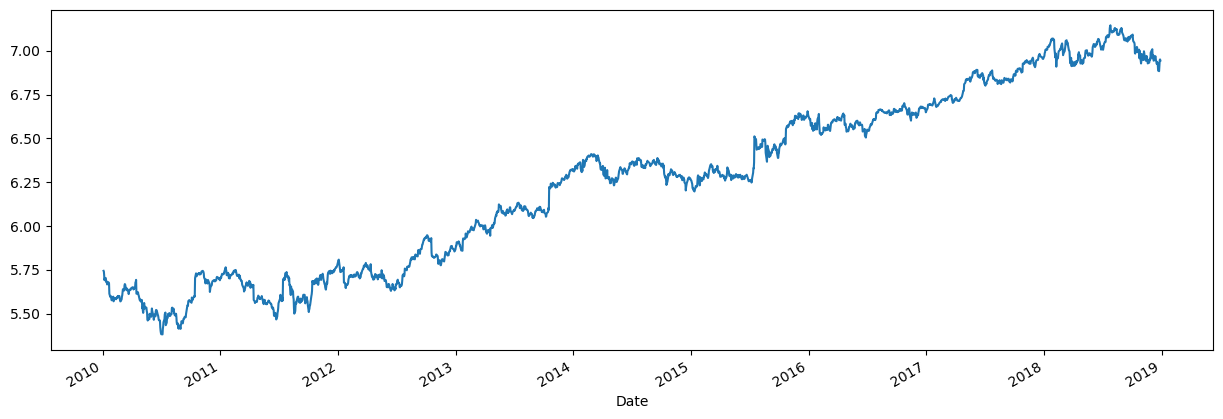

In [12]:
goog['LogClose'].plot(figsize=(15,5))

In [13]:
# goog.index.freq='B'

In [22]:
Ntest=30
train=goog.iloc[:-Ntest]
test=goog.iloc[-Ntest:]

In [23]:
# boolean series to index df rows
train_idx=goog.index<=train.index[-1]
test_idx=goog.index>train.index[-1]

In [24]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [25]:
hw=ExponentialSmoothing(
train['LogClose'],
initialization_method='legacy-heuristic',
trend='add',seasonal=None)
res_hw=hw.fit()


C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


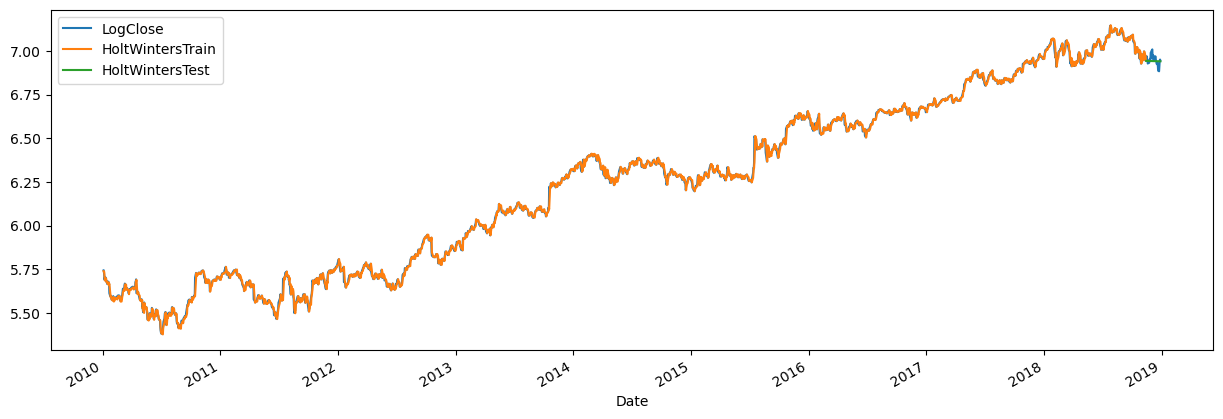

In [26]:
goog.loc[train_idx,'HoltWintersTrain']=res_hw.fittedvalues
goog.loc[test_idx,'HoltWintersTest']=res_hw.forecast(Ntest).to_numpy()
goog[['LogClose','HoltWintersTrain','HoltWintersTest']].plot(figsize=(15,5));

<Axes: xlabel='Date'>

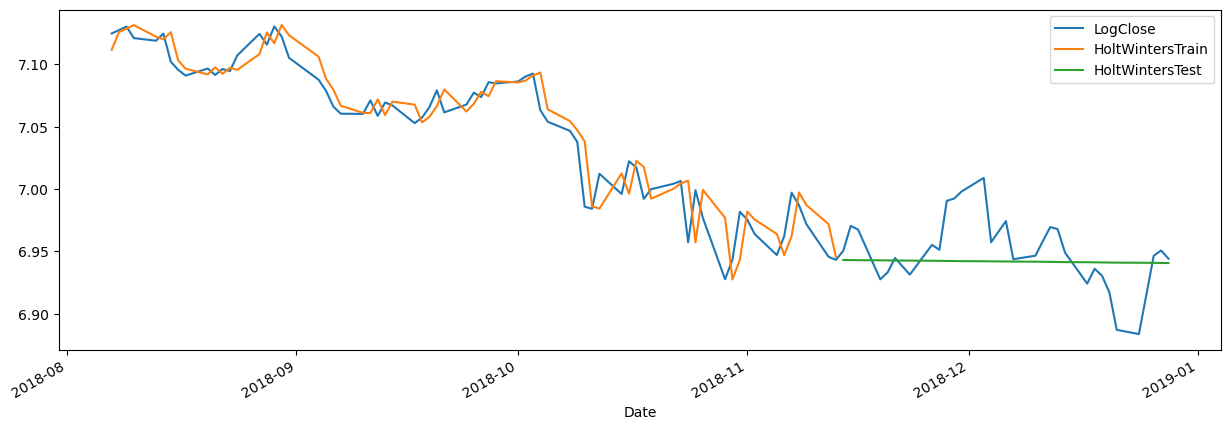

In [29]:
cols=['LogClose','HoltWintersTrain','HoltWintersTest']
goog.iloc[-100:][cols].plot(figsize=(15,5))

In [30]:
goog.loc[test_idx,'Naive']=train.iloc[-1]['LogClose']

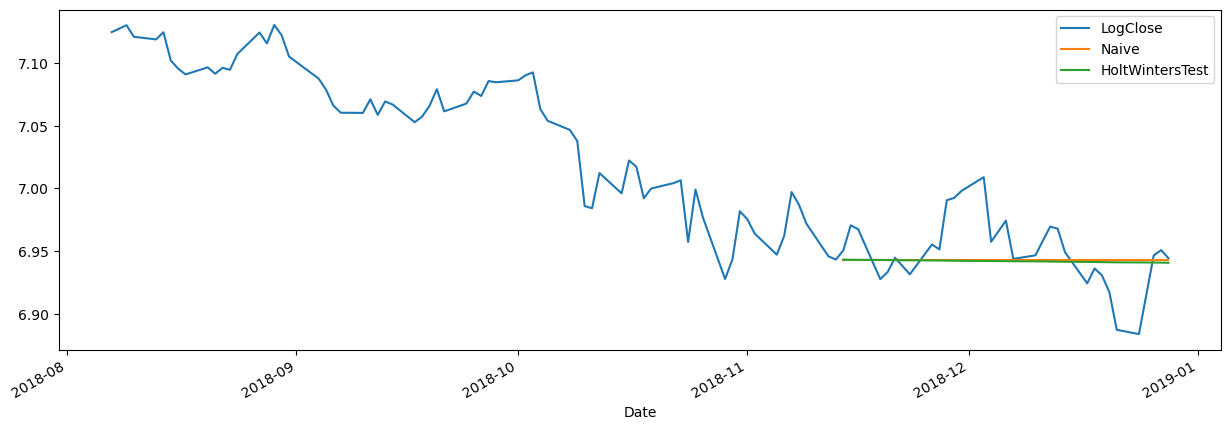

In [31]:
goog.iloc[-100:][['LogClose','Naive','HoltWintersTest']].plot(figsize=(15,5));

In [33]:
r2_score(goog.loc[test_idx,'LogClose'],goog.loc[test_idx,'Naive'])

-0.06454209862026317

In [34]:
r2_score(goog.loc[test_idx,'LogClose'],goog.loc[test_idx,'HoltWintersTest'])

-0.0711416925353805

In [27]:
r2_score(train['LogClose'],res_hw.fittedvalues)

0.9990358751026999

In [28]:
r2_score(test['LogClose'],res_hw.forecast(Ntest))

C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\asus\anaconda31\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


-0.0711416925353805